# Dueling Deep Q-Network (DQN) using PyTorch
Environment: LunarLander-v2

### Import the Necessary Packages

In [168]:
import gym
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
import torch
from pyvirtualdisplay import Display
import numpy as np
import random
from collections import namedtuple, deque
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
display = Display(visible=0, size=(1400, 900))
display.start()

is_ipython = 'inline' in plt.get_backend()
if is_ipython:
    from IPython import display
    
plt.ion()

## Specify the Environment, and Explore the State and Action Spaces
* Let's begin with an initializing the environment


In [169]:
# Create an environment
env = gym.make('CartPole-v1')
print('State space: ', env.observation_space)
print('State shape: ', env.observation_space.shape)

print('Action space: ', env.action_space)
print('Number of actions: ', env.action_space.n)


State space:  Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
State shape:  (4,)
Action space:  Discrete(2)
Number of actions:  2


### Implement Q-Network
Building the Network: Actor (policy) Model
input_size = state_size
output_size = action_size
using same seed
hidden_layers: fc1, fc2

<!-- Define Layer of model: [FC-RELU-FC-RELU-FC] -->



In [170]:


class MaxQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):

        super(MaxQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        # Add the first laer, input to hidden layer
        self.fc1 = nn.Linear(state_size, fc1_units)
        # Add more hidden layer
        self.fc2 = nn.Linear(fc1_units, fc2_units)

        # State-value V
        self.V = nn.Linear(fc2_units, 1)
        
        # Advantage function A
        self.A = nn.Linear(fc2_units, action_size)
        
        
    def forward(self, state):

        features = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU()
        )
        V = self.V(features(state))
        A = self.A(features(state))
        A_max = A.max(dim=1, keepdim=True)[0]
        A_max_expanded = A_max.expand(-1, A.size(1))

        return V + (A - A_max_expanded)
    
    
class MeanQNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, fc1_units=64, fc2_units=64):

        super(MeanQNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.V = nn.Linear(fc2_units, 1)
        self.A = nn.Linear(fc2_units, action_size)
        
        
    def forward(self, state):

        features = nn.Sequential(
            self.fc1,
            nn.ReLU(),
            self.fc2,
            nn.ReLU()
        )
        V = self.V(features(state))
        A = self.A(features(state))
        return V + (A - A.mean(dim=1, keepdim=True))
        

In [171]:
import numpy as np
import random
from collections import namedtuple, deque

class ReplayBuffer:
    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.acion_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):

        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device) # gpu
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        # return D
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)
        
        
        

### Implement agent
* Agent(state_size=8, action_size=4, seed=0)

In [172]:

# HYPERPARAMETERS
LR = 2.5e-3                # learning rate # 2.5e-3
BUFFER_SIZE = int(1e5)   # replay buffer size N # 1e5
BATCH_SIZE = 128          # minibatch size # 128
UPDATE_EVERY = 5         # how often to update the network # 5
GAMMA = 0.99             # Discount factor # 0.99
TAU = 1e-2               # for soft update of target parameters # 1e-2


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class Agent():

    def __init__(self, state_size, action_size, seed, DuelingDQN):
       
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.qnetwork_local = DuelingDQN(state_size, action_size, seed).to(device) 
        self.qnetwork_target = DuelingDQN(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR) 
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
        
    def step(self, state, action, reward, next_state, done):
        self.memory.add(state, action, reward, next_state, done)
        self.t_step =(self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            if len(self.memory) > BATCH_SIZE: 
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
                
    def act(self, state, eps=0.1):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        ''' Epsilon-greedy action selection (Already Present) '''
        action_values = torch.tensor(action_values, dtype=torch.float32)
        action_probs = torch.softmax(action_values, dim=1)
        chosen_action = torch.multinomial(action_probs, 1).item()
        return chosen_action
        
    def learn(self, experiences, gamma):
        states, actions, rewards, next_states, dones = experiences
        Q_targets_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        Q_expected = self.qnetwork_local(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU) 
        
    def soft_update(self, local_model, target_model, tau):
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)
        
        
        
        
        

In [173]:
def dqn(env, agent, n_episodes = 500, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.995):

    scores_window = deque(maxlen=100)
    scores_array = []
    eps = eps_start
    reward_sat=False
    reahced_flag = False
    for i_episode in range(1, n_episodes + 1):
        state = env.reset()[0]
        # print(state)
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps)
            next_state, reward, done, _, _ = env.step(action)
            if not reward_sat:
                agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
    
    
        scores_window.append(score)
        scores_array.append(np.mean(scores_window))
        eps = max(eps_end, eps_decay * eps)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")

        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if np.mean(scores_window) >= 475 and not reahced_flag:
            reahced_flag = True
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
            reward_sat=True
    return scores_array


In [174]:
#deuling dqn
def run_agent(env, DuelingDQN, state_shape, action_shape):
    scores_final = []
    for i in range(5):
        # Assuming env, TutorialAgent, and other required variables are defined
        agent = Agent(state_size=state_shape, action_size=action_shape, seed=np.random.randint(1,100), DuelingDQN = DuelingDQN)
        scores_array = dqn(env, agent)
        scores_final.append(scores_array)
    scores = np.array(scores_final)
    scores = np.mean(scores, axis=0)

    return scores

In [175]:
env = gym.make('CartPole-v1')
print("Environment : CartPole-v1")
average_mean_cartpole = run_agent(env=env, DuelingDQN=MeanQNetwork, state_shape = env.observation_space.shape[0], action_shape = env.action_space.n)

Environment : CartPole-v1
Episode 12	Average Score: 16.83

/tmp/ipykernel_322266/2929858312.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_values = torch.tensor(action_values, dtype=torch.float32)
/home/adi/miniconda3/envs/rl/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 21.09
Episode 200	Average Score: 46.55
Episode 300	Average Score: 185.44
Episode 400	Average Score: 187.77
Episode 445	Average Score: 481.65
Environment solved in 445 episodes!	Average Score: 481.65
Episode 500	Average Score: 902.44
Episode 100	Average Score: 20.32
Episode 200	Average Score: 35.09
Episode 300	Average Score: 214.71
Episode 400	Average Score: 222.84
Episode 465	Average Score: 483.04
Environment solved in 465 episodes!	Average Score: 483.04
Episode 500	Average Score: 744.35
Episode 100	Average Score: 21.38
Episode 200	Average Score: 42.22
Episode 300	Average Score: 162.59
Episode 400	Average Score: 153.26
Episode 500	Average Score: 221.04
Episode 100	Average Score: 20.75
Episode 200	Average Score: 36.80
Episode 300	Average Score: 231.42
Episode 375	Average Score: 475.57
Environment solved in 375 episodes!	Average Score: 475.57
Episode 400	Average Score: 611.57
Episode 500	Average Score: 835.15
Episode 100	Average Score: 24.02
Episode 200	Average

In [176]:
def plot_rewards(all_rewards, name):
    average_rewards = []
    for i in range(0, len(all_rewards)):
        if i < 100:
            average_rewards.append(np.mean(all_rewards[:i+1]))
        else:
            average_rewards.append(np.mean(all_rewards[i-99:i+1]))
    
    std_dev = np.std(average_rewards)
    x = np.arange(0,len(average_rewards))
    plt.fill_between
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.plot(x, average_rewards, label='average rewards')
    plt.fill_between(x,
                     np.array(average_rewards) - std_dev,
                     np.array(average_rewards) + std_dev,
                     color='blue', alpha=0.2, label='± 1 SD')
    plt.title(f'Rewards vs Episodes for {name}')
    plt.legend()
    plt.show()

In [177]:
env = gym.make('CartPole-v1')
print("Environment : CartPole-v1")
average_max_cartpole = run_agent(env=env, DuelingDQN=MaxQNetwork, state_shape = env.observation_space.shape[0], action_shape = env.action_space.n)

Environment : CartPole-v1
Episode 8	Average Score: 15.25

/tmp/ipykernel_322266/2929858312.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  action_values = torch.tensor(action_values, dtype=torch.float32)


Episode 100	Average Score: 22.91
Episode 200	Average Score: 39.96
Episode 300	Average Score: 179.20
Episode 400	Average Score: 167.40
Episode 500	Average Score: 212.54
Episode 100	Average Score: 22.79
Episode 200	Average Score: 43.09
Episode 300	Average Score: 203.63
Episode 400	Average Score: 242.96
Episode 434	Average Score: 480.41
Environment solved in 434 episodes!	Average Score: 480.41
Episode 500	Average Score: 954.72
Episode 100	Average Score: 21.56
Episode 200	Average Score: 35.23
Episode 300	Average Score: 178.08
Episode 400	Average Score: 203.79
Episode 453	Average Score: 480.92
Environment solved in 453 episodes!	Average Score: 480.92
Episode 500	Average Score: 847.80
Episode 100	Average Score: 20.81
Episode 200	Average Score: 67.58
Episode 300	Average Score: 178.34
Episode 400	Average Score: 215.23
Episode 457	Average Score: 480.14
Environment solved in 457 episodes!	Average Score: 480.14
Episode 500	Average Score: 799.69
Episode 100	Average Score: 21.96
Episode 200	Average

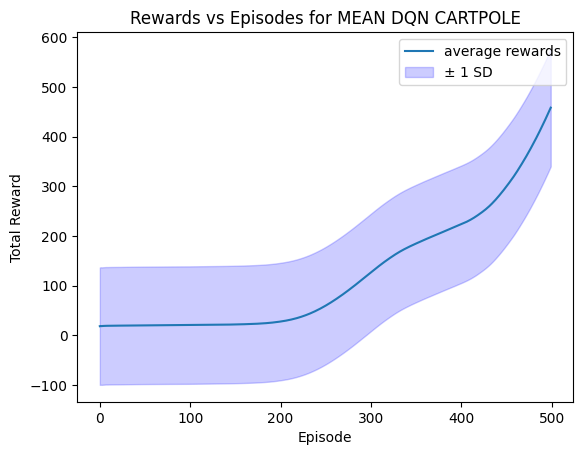

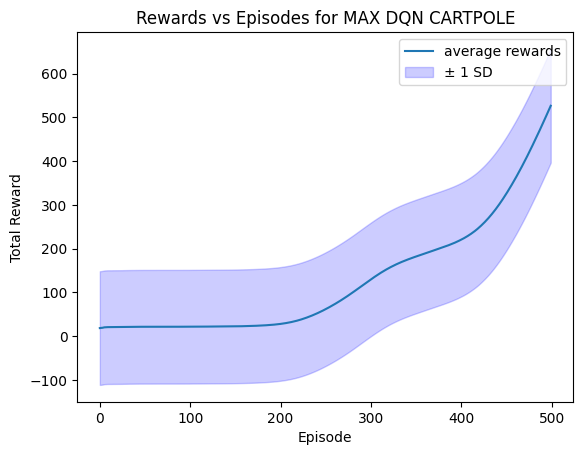

In [178]:
plot_rewards(average_mean_cartpole, "MEAN DQN CARTPOLE")
plot_rewards(average_max_cartpole, "MAX DQN CARTPOLE")

In [179]:
np.save("/home/adi/courses/reinforcement_learning/assignment/Assignment_2/RL_Assignment_2_ED21B005_ED21B046/mean_cartpole.npy", average_mean_cartpole)
np.save("/home/adi/courses/reinforcement_learning/assignment/Assignment_2/RL_Assignment_2_ED21B005_ED21B046/max_cartpole.npy", average_max_cartpole)